# What's New in Python 3.11 And Should You Even Bother With It?
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@markuswinkler?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Markus Winkler</a>
    </strong>
</figcaption>

## Introduction

Python won the "Language of the Year" award three times in the last four years. Even though it doesn't seem it will win this year, the titan language is still on top of the TIOBE index and it will probably stay for there for quite some time.

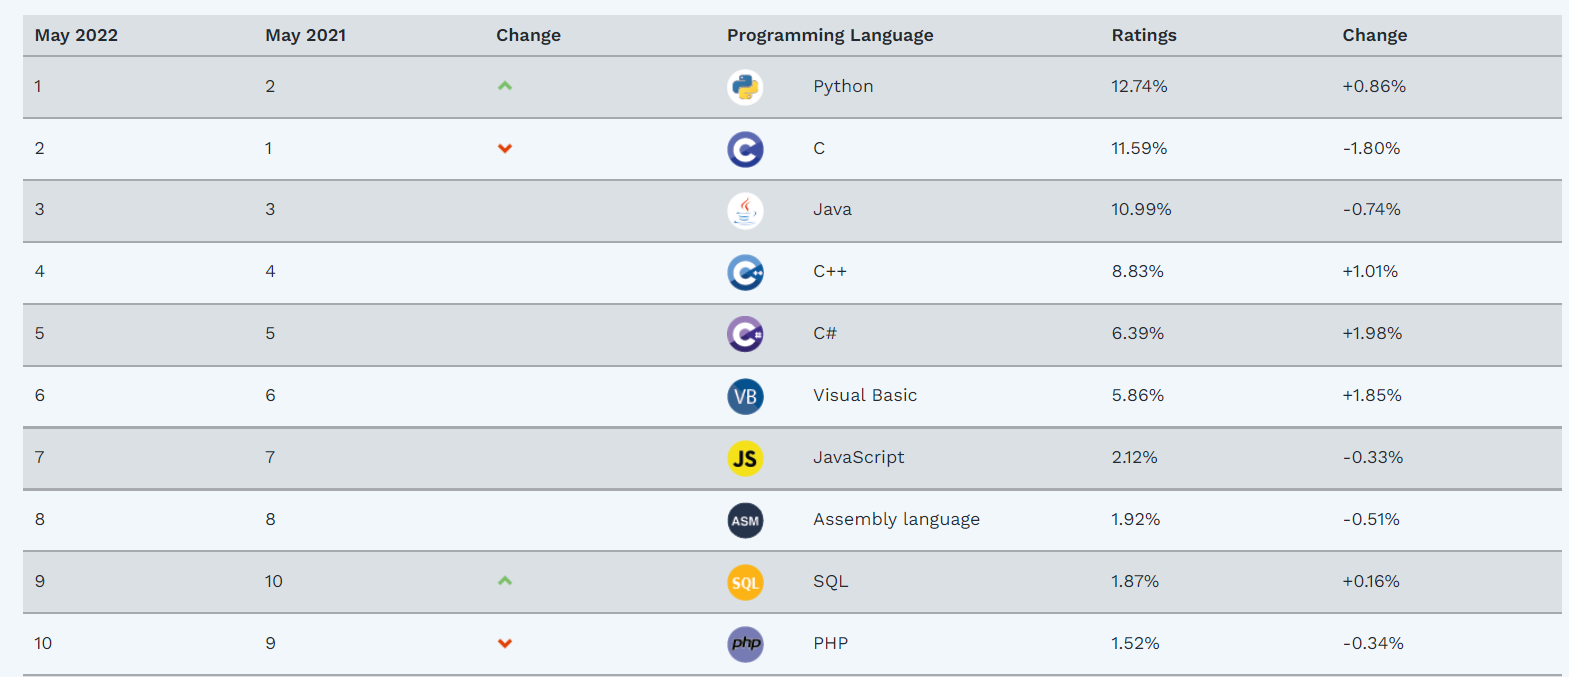

12.74% rating means that out of all programming-related search engine queries, the keyword Python popped up about ~13% of the time. In other words, every 7th or 8th programming question on the Internet is about Python (let that sink in, Python haters). 

Today, Python is frequently associated with the biggest breakthroughs in data science and AI. People love it for its simplicity, its humongous set of built-in and third-party libraries for any task imaginable and its community. 

With the final stable version of 3.11 coming on October 3, 2022, Python community can enjoy various updates that include a massive speed increase, better error handling and debugging and numerous quality-of-life improvements to the standard libraries. 

## What are Python 3.11 features?

[Python 3.11 changelog](https://docs.python.org/3.11/whatsnew/changelog.html#changelog) shows nearly endless bug fixes, improvements and additions, most of which you will never use or even notice changed. However, there are a few critical new features that might significantly improve your Python workflow when the stable release comes. I will be outlining them here. 

### 1. Speed improvement

The first major news everyone is excited about is the speed improvement. However, don't get your hopes up too much as the new speed is only about 25% higher than 3.10. The Python docs claim it can be up to 60% in certain cases. Let's test how much of these claims are true. 

To compare the speeds of Python 3.10 and 3.11, you will need a [docker installation](https://www.docker.com/). After making sure Docker desktop is running, run these two commands in the terminal, which will download two images for the two versions of Python.

```bash
$ docker run -d python:3.10.4-bullseye

$ docker run -d python:3.11-rc-bullseye
```

The downloaded images should be visible in your Docker dashboard, where you can also fire them up:

![](images/docker_images_2.gif)

After you launch the containers, you can run `docker ps` to see details like ID, name and status:

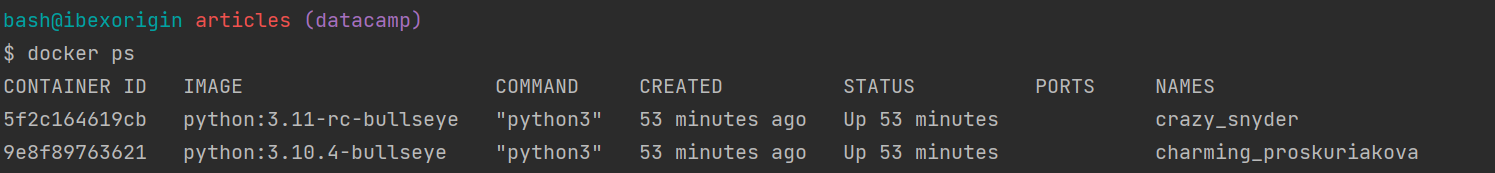

The running containers are also visible under the Containers tab in your dashboard, where you will also find CLI buttons next to "Run/Stop". Click them for both containers to launch two terminal tabs attached to the containers.

In both tabs, install the `pyperformance` package via pip.

Then, run the below commands in each container terminals.

For Python 3.10:

```bash
$ pyperformance run -r -o py310.json
```

For Python 3.11:

```bash
$ pyperformance run -r -o py311.json
```

These commands will run benchmark tests for about 60 Python functions from standard libraries and produce JSON metadata. I've optionally added the `-r` tag to tell `pyperformance` I want the tests to be rigorous, which takes more time.

> Both containers are running on a Windows machine with AMD Ryzen 12-core CPU. 

Now, we have two JSON files in two containers. We will need to put both in a single directory to continue the speed test. For that, we will use the `docker cp` command to copy the JSON file from Python 3.11 container to 3.10. 

Run the below commands in a separate terminal tab:

```bash
$ docker cp crazy_snyder:/py311.json C:/Users/bex/Desktop

$ docker cp C:/Users/bex/Desktop/py311.json charming_proskuriakova:/
```

> `crazy_snyder` and `charming_proskuriakova` are the IDs of the running containers.

Now, both JSON files are in the Python 3.10 container. To complete the benchmark and save the results as a CSV, run the below commands:

```bash
$ pyperformance compare py310.json py311.json --csv comparison.csv

$ docker cp charming_proskuriakova:/comparison.csv C:/Users/bex/Desktop/articles
```

Finally, let's load the CSV into Pandas and analyze it:

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/comparison.csv")
df.rename(
    {"Base": "py310", "Changed": "py311", "Benchmark": "function"},
    axis=1,
    inplace=True,
)

df.shape

(59, 3)

In [19]:
df.sample(5)

,function,py310,py311
40,scimark_monte_carlo,0.12392,0.08052
19,mako,0.01967,0.01289
1,chameleon,0.01131,0.00843
8,float,0.14265,0.09133
35,regex_effbot,0.00315,0.00261


Each row in the dataframe records how much time it took (in milliseconds) for both versions to run the given Python function. 

Let's plot a histogram of speedups:

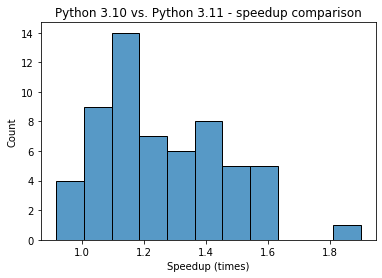

In [24]:
df["speed_up"] = (df["py310"] / df["py311"]).round(3)

fig, ax = plt.subplots()

sns.histplot(df["speed_up"], bins=11)
ax.set(
    xlabel="Speedup (times)", title="Python 3.10 vs. Python 3.11 - speedup comparison"
)

plt.show();

It is clear from the plot that the majority of functions in Python 3.11 were about 1.2 times faster. We can also confirm the estimate with the mean and median:

In [21]:
df["speed_up"].mean()

1.2605593220338982

In [5]:
df["speed_up"].median()

1.207

It seems there is one case where the speedup was ~1.9:

In [6]:
df["speed_up"].max()

1.899

There are also four cases where Python 3.10 was faster than the new version:

In [26]:
(df["speed_up"] <= 1).sum()

4

The speedup is definitely noticeable, but I am reserving judgement on whether it will be of any real use. We have only tested the speed on pure Python functions, which you don't use in your every day work.

### 2. Better error messages

The most exciting feature of Python 3.11 is, perhaps, better error messages that pinpoint the exact location of the error. Gone are the days where you would get a 100-line traceback ending with the stupidest of error messages that even Google had trouble understanding.

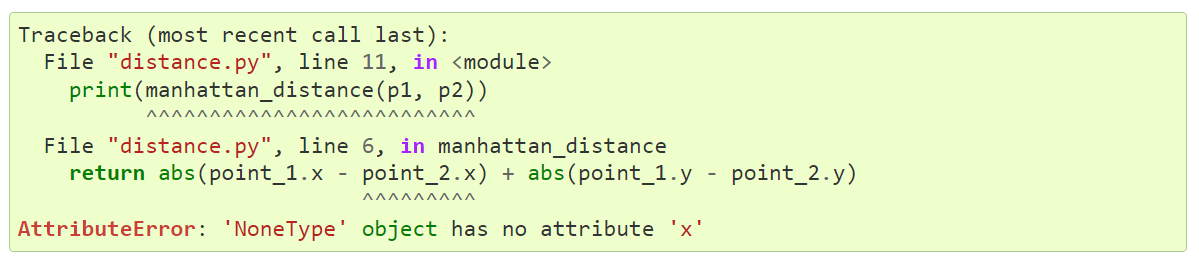

In the above example, the Python interpreter is pointing to the `x` that crashed the script because of its `None` value. The error would have been rather ambiguous in current versions of Python as there are two objects with `x` attribute. 

Another example shows an error from a deeply nested dictionary, clearly showing to which key the error belongs to.

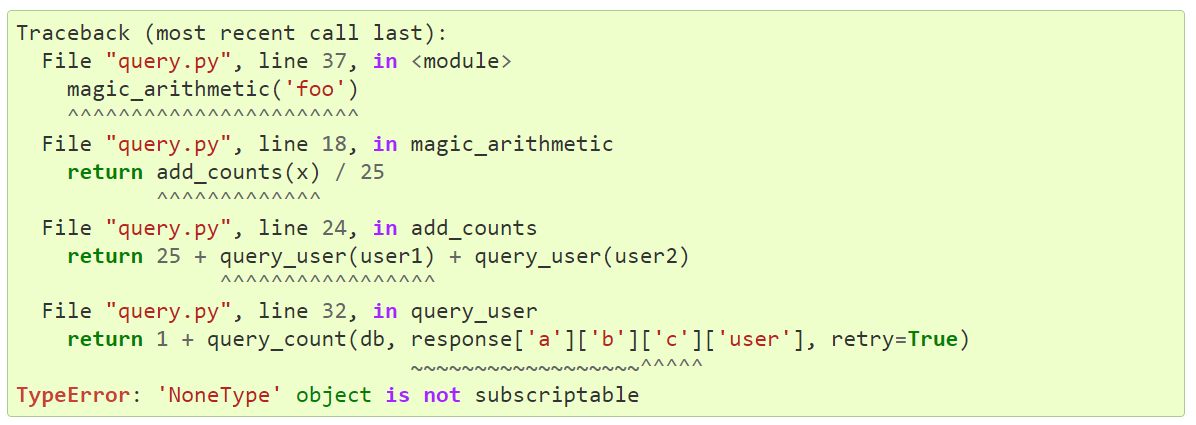

You can see the same precision in complex arithmetic expressions:

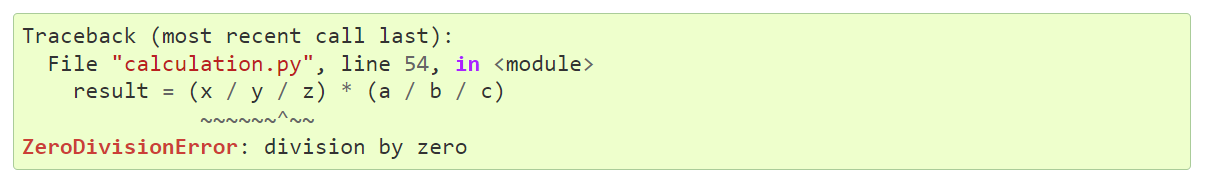

It is pretty cool feature to have, especially for data scientists as they are not much experienced in debugging scripts.

### 3. Exception notes

> Explicit is better than implicit.

The above sentence is literally the second line of [the Zen of Python](https://peps.python.org/pep-0020/). It refers to one of the 20 design patters of Python, which represents the rule that Python code should be as expressive as possible. 

To reinforce this design pattern, Python 3.11 introduces exception notes ([PEP 678](https://peps.python.org/pep-0678/#example-usage)). Now, inside your `except` clauses, you can call the `add_note` function and pass a custom message when you raise an error:

```python
import math

try:
    math.sqrt(-1)
except ValueError as e:
    e.add_note("Negative value passed! Please try again.")
    raise
```

![](images/error.gif)

If you are going for a custom exception class like below, you can add *multiple* notes to the class inside the protected class-level attribute *__notes__*:

```python
import math


class MyOwnError(Exception):
    # Should be a list of strings
    __notes__ = ["This is a custom error!"]


try:
    math.sqrt(-1)
except:
    raise MyOwnError
```
![](images/error_class.gif)

Now, when the interpreter hits the error, it will display the custom message after the regular message body.

There is also a new syntax to raise exceptions with the `except*` clause, which is used along with the new `ExceptionGroup` class. [PEP 654](https://peps.python.org/pep-0678/#example-usage) says that it can be used to raise multiple unrelated errors simultaneously in variety of scenarios. Most of these situations are too niche like working with web sockets, programming concurrently with `asyncio`, etc. which almost never comes up in everyday data science work, so I won't explain the new syntax here. 

### 4. New typing feature: Self

If you are serious about making your code readable and easy to debug, [static typing](https://realpython.com/python-type-checking/#:~:text=Static%20type%20checks%20are%20performed,a%20different%20type%20may%20exist.) is practically a must. 

Defining the exact type of your variables, function inputs and outputs may save you hours of debugging time and make reading your code a delight to others. Besides, adding typing annotations will make modern IDEs very happy as they often display function definitions as you type their names, making your functions easier to use for others. 

Until now, the powerful `typing` module in Python had classes for virtually any data type, except for classes that return instances of themselves. 

```python
from typing import Self


class Language:

    def __init__(self, name, version, release_date):
        self.name = name
        self.version = version
        self.release_date = release_date

    def change_version(self, version) -> Self:
        self.version = version

        return Language(self.name, self.version, self.release_date)
```
![](images/self.gif)

Now, Python 3.11 introduces the `Self` class which can be added to a function's definition if its return value is `self` or a new instance of the class itself.

### 5. Improvements to the standard libraries

There are a few other quality-of-life improvements to the standard libraries. First of all, two long-awaited functions are added to the `math` module:

```python
>>> import math
>>> math.cbrt(9)  # Find the cube-root of x
2.080083823051904
>>> math.cbrt(27)
3.0000000000000004
>>> math.exp2(5)  # Raise 2 to the power of x
32.0
```

The fact that Python is adding the `cbrt` function after 28 years since its release is pretty embarrassing. In comparison, Julia has had it since its initial release along with dozens of well-known math functions that don't even need importing. 

The `fractions` module also added a new feature that lets you create fractions from strings:

```python
>>> from fractions import Fraction
>>> Fraction("22/7")  # New in Python 3.11
Fraction(22, 7)
>>> Fraction(numerator=22, denominator=7)
Fraction(22, 7)
>>> Fraction("3e-4")
Fraction(3, 10000)
>>> Fraction("-73/41")
Fraction(-73, 41)
>>> Fraction(3.1415)  # Find the closest approximation to the given float
Fraction(7074029114692207, 2251799813685248)
```

As you can see, `fractions` module can be very useful for certain arithmetic operations. Especially, I like how you can find the closest fraction that approximates the given float. You can take this a step further by providing a denominator limit:

```python
>>> from math import pi
>>> Fraction(pi).limit_denominator(100000)
Fraction(312689, 99532)
```

There is also a new module called `tomllib` for parsing TOML documents. TOML (Tom's Obvious Minimal Language) is a popular file format for writing human-readable configuration files. Here is an image from the [project's homepage](https://toml.io/en/):

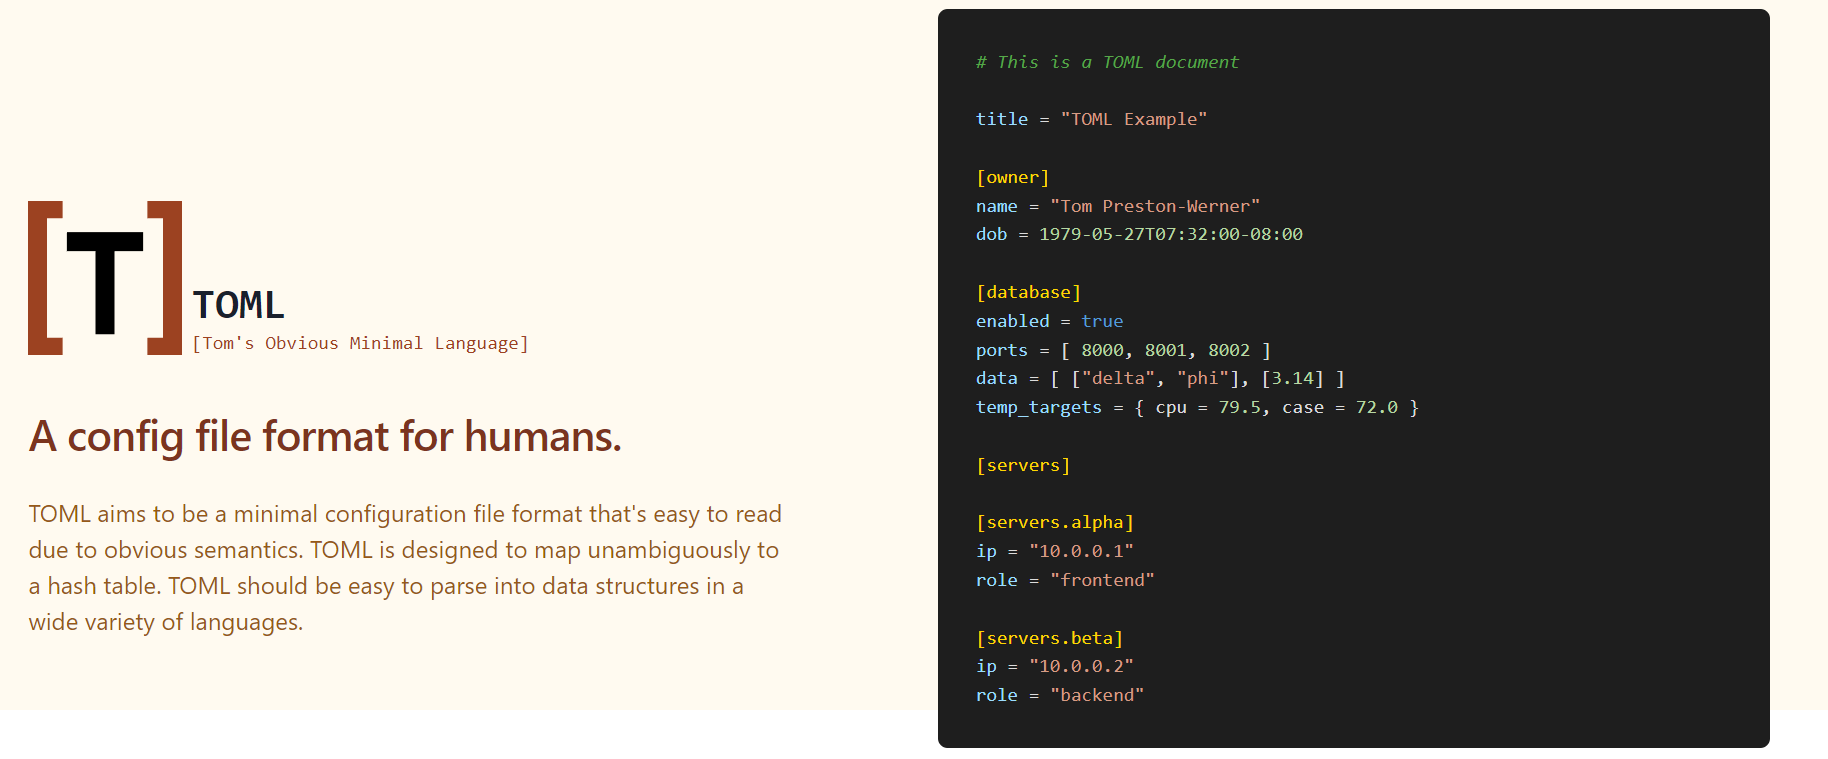

```python
import tomllib

toml_str = """
python-version = "3.11.0"
release_date = "2022-10-22"
"""

data = tomllib.loads(toml_str)
print(data)  # {'python-version': '3.11.0', 'release_date': '2022-10-22'}
print(data['python-version'])  # 3.11.0
print(data['release_date'])  # 2022-10-22

```

## When will Python 3.11 be released? 

The development of Python 3.11 started on May 5, 2021. Since then, seven alpha versions were released, ending at the first beta version on May 8, 2022. After this date till the official release, there won't be new features introduced. 

The final, stable release will come out on October 3, 2022 (a nice birthday surprise for me!) after three more beta versions and two candidate versions in the meantime. 